# Applying Classification Modeling
The goal of this week's assessment is to find the model which best predicts whether a person will default on their loan. In doing so, we want to utilize all of the different tools we have learned over the course: data cleaning, EDA, feature engineering/transformation, feature selection, hyperparameter tuning, and model evaluation. 

Dataset: The dataset comes customers default payments in Taiwan. More information about the dataset and columns are found in the link below.

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#


You will fit three different models (KNN, Logistic Regression, and Decision Tree Classifier) and use gridsearch to find the best hyperparameters for those models. Then you will compare the performance of those three models on a test set to find the best one.  


## Process/Expectations

#### You will be working in pairs for this assessment; please have ONE notebook and be prepared to explain how you worked in your pair.
1. Clean up your data set so that you can do EDA. This includes handling null values, categorical variables, removing unimportant columns, and removing outliers.
2. Perform EDA to identify opportunities to create new features.
    - [Great Example of EDA for classification](https://www.kaggle.com/stephaniestallworth/titanic-eda-classification-end-to-end) 
    - [Using Pairplots with Classification](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166)
3. Create polynomial and/or interaction features. You must also create at least 2 new features that are not interactions or polynomial transformations. For example, you can create a new dummy variable that based on the value of a continuous variable (billamount6 >2000) or take the average of some past amounts.
4. Perform some feature selction. This can happen beforehand using F-scores, or you can do it as part of your model building process by looking at the weights of your regularized logistic regression or feature importance of your decision tree.  
5. You must fit each of the three models to your data and tune at least 1 hyperparameter per model. 
6. After identifying the best hyperparameters for each model, fit those models to the test set and identify the best model overall using the evaluation metric of your choice.
7. Present your best model.

In [55]:
# import libraries
import pandas as pd
from math import exp
from scipy.stats import norm
from scipy import stats
import seaborn as sns
import numpy as np
import datetime as dt

from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf

from sklearn.metrics import mean_squared_error
import math

import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
import pandas as pd
import numpy as np

# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.metrics import make_scorer, accuracy_score #Import scikit-learn metrics module for accuracy calculation

## 1. Data Cleaning

In [2]:
df = pd.read_csv('student_data.csv')

In [4]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,2873,350000,1,1,2,37,-2,-2,-2,-2,...,466,466,316,316,316,466,466,316,316,0
1,3598,50000,2,2,1,37,2,2,2,0,...,13026,13268,13497,5500,0,580,600,600,600,0
2,27623,50000,2,1,2,23,-1,-1,-1,-1,...,4800,9810,660,2548,2321,4800,9810,660,2980,0
3,6874,20000,1,3,1,56,0,0,0,0,...,13784,13420,13686,1508,1216,1116,0,490,658,0
4,6444,110000,2,2,2,32,0,0,0,0,...,108829,110557,106082,5400,5400,4100,4100,4100,4200,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23999 entries, 0 to 23998
Data columns (total 25 columns):
ID                            23999 non-null int64
LIMIT_BAL                     23999 non-null int64
SEX                           23999 non-null int64
EDUCATION                     23999 non-null int64
MARRIAGE                      23999 non-null int64
AGE                           23999 non-null int64
PAY_0                         23999 non-null int64
PAY_2                         23999 non-null int64
PAY_3                         23999 non-null int64
PAY_4                         23999 non-null int64
PAY_5                         23999 non-null int64
PAY_6                         23999 non-null int64
BILL_AMT1                     23999 non-null int64
BILL_AMT2                     23999 non-null int64
BILL_AMT3                     23999 non-null int64
BILL_AMT4                     23999 non-null int64
BILL_AMT5                     23999 non-null int64
BILL_AMT6               

In [6]:
df.drop(columns = ['ID'], inplace = True)

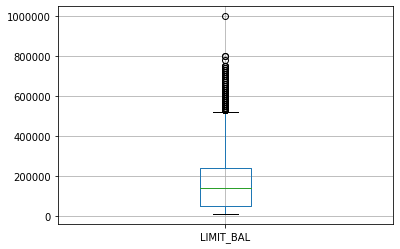

In [7]:
df.boxplot('LIMIT_BAL')

In [8]:
df.loc[df['LIMIT_BAL']>900000]
df.drop(index=[13774], inplace=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24]), <a list of 24 Text xticklabel objects>)

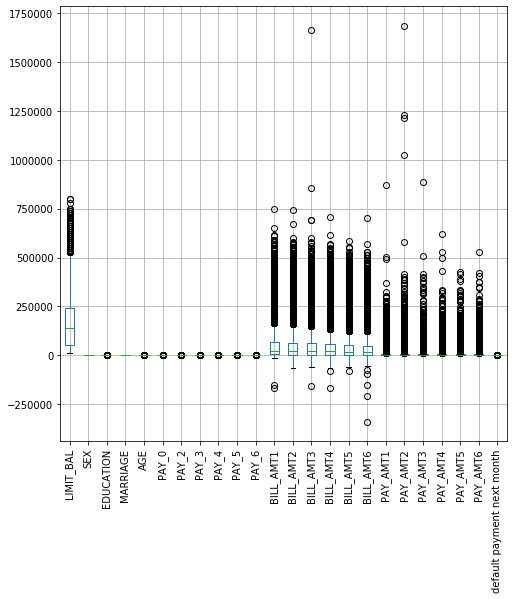

In [9]:
pd.DataFrame.boxplot(df,figsize=(8,8))
plt.xticks(rotation=90)

## 2. EDA

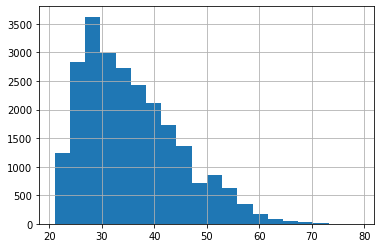

In [10]:
df['AGE'].hist(bins=20)

## 3. Feature Engineering

In [11]:
sex_dummies = pd.get_dummies(df['SEX'], prefix='sex')
education_dummies = pd.get_dummies(df['EDUCATION'], prefix='education')
marriage_dummies = pd.get_dummies(df['MARRIAGE'], prefix='marriage')
df = pd.concat([df, sex_dummies, education_dummies, marriage_dummies], axis=1)

In [12]:
df.drop(columns = ['SEX', 'EDUCATION', 'MARRIAGE'], inplace = True)

Text(0.5, 1.0, 'Compare')

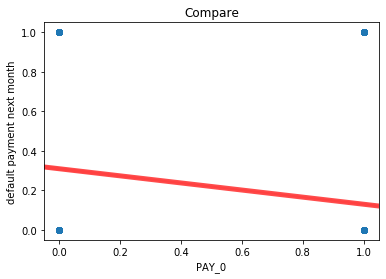

In [13]:
sns.regplot(x=df['PAY_0']==0, y=df['default payment next month'],line_kws={"color":"r","alpha":0.7,"lw":5}).set_title('Compare')

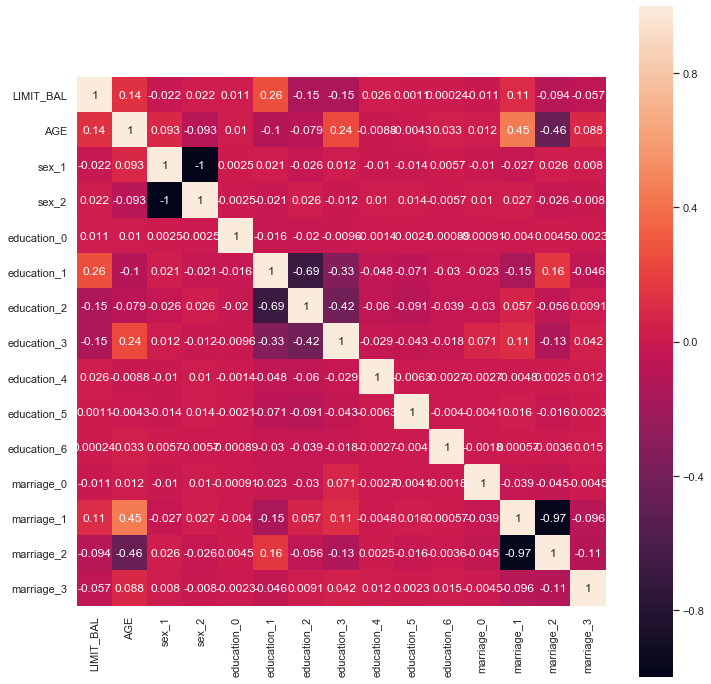

In [23]:
corrmat = df[['LIMIT_BAL', 'AGE','sex_1', 'sex_2', 'education_0', 'education_1', 'education_2',
       'education_3', 'education_4', 'education_5', 'education_6',
       'marriage_0', 'marriage_1', 'marriage_2', 'marriage_3']].corr()
# 'PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
sns.set(font_scale=1)
fig,ax= plt.subplots()
fig.set_size_inches(10,10)
plt.tight_layout()
sns.heatmap(corrmat,square=True,annot=True, cbar = True)

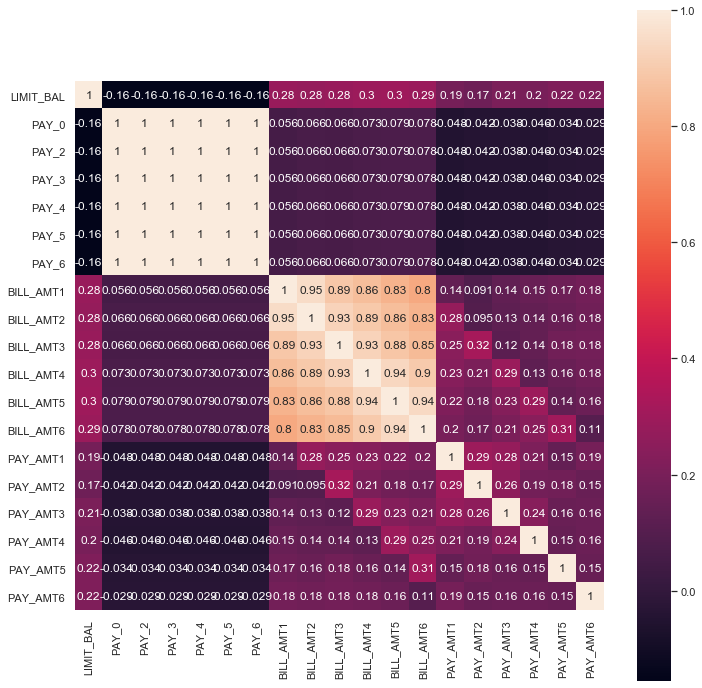

In [39]:
corrmat = df[['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',\
              'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', \
              'BILL_AMT6', 'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',\
              'PAY_AMT6']].corr()
sns.set(font_scale=1)
fig,ax= plt.subplots()
fig.set_size_inches(10,10)
plt.tight_layout()
sns.heatmap(corrmat,square=True,annot=True, cbar = True)

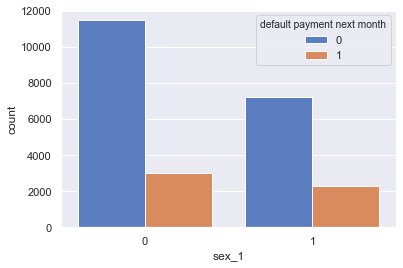

In [16]:
sns.countplot(x="sex_1", data=df,hue="default payment next month", palette="muted")

In [17]:
df.PAY_0 = np.where(df.PAY_0 < 2 , 0, df.PAY_0)
df.PAY_0 = np.where(df.PAY_0 >=2 , 1, df.PAY_0)

df.PAY_2 = np.where(df.PAY_2 < 2 , 0, df.PAY_0)
df.PAY_2 = np.where(df.PAY_2 >=2 , 1, df.PAY_0)

df.PAY_3 = np.where(df.PAY_3 < 2 , 0, df.PAY_0)
df.PAY_3 = np.where(df.PAY_3 >=2 , 1, df.PAY_0)

df.PAY_4 = np.where(df.PAY_4 < 2 , 0, df.PAY_0)
df.PAY_4 = np.where(df.PAY_4 >=2 , 1, df.PAY_0)

df.PAY_5 = np.where(df.PAY_5 < 2 , 0, df.PAY_0)
df.PAY_5 = np.where(df.PAY_5 >=2 , 1, df.PAY_0)

df.PAY_6 = np.where(df.PAY_6 < 2 , 0, df.PAY_0)
df.PAY_6 = np.where(df.PAY_6 >=2 , 1, df.PAY_0)

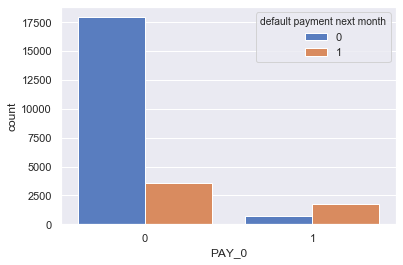

In [21]:
sns.countplot(x="PAY_0", data=df,hue="default payment next month", palette="muted")

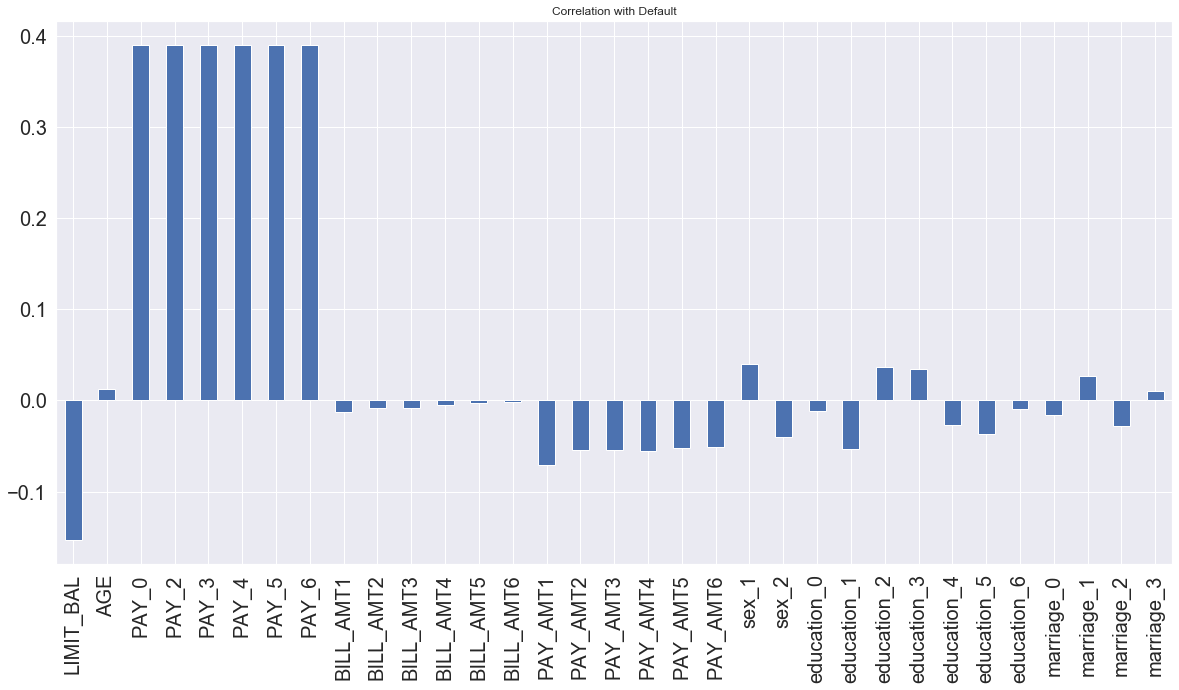

In [32]:
X = df.drop(['default payment next month'],axis=1)
y = df['default payment next month']

X.corrwith(df['default payment next month']).plot.bar(
        figsize = (20, 10), title = "Correlation with Default", fontsize = 20,
        rot = 90, grid = True)

## 4. Feature Selection

In [ ]:
# recursive feature selection

In [ ]:
min_train = X_train.min()
range_train = (X_train - min_train).max()
X_train_scaled = (X_train - min_train)/range_train

In [ ]:
min_test = X_test.min()
range_test = (X_test - min_test).max()
X_test_scaled = (X_test - min_test)/range_test

## 5. Model Fitting and Hyperparameter Tuning
KNN, Logistic Regression, Decision Tree

### Logistic Regression

In [ ]:
# Logistic Regression
# gridsearch/tune hyperparameters

In [57]:
fit a logistic regression model and store the class predictions
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
feature_cols = ['al']
X = glass[feature_cols]
y = glass.household
logreg.fit(X, y)
glass['default payment next month'] = logreg.predict(X)

SyntaxError: invalid syntax (<ipython-input-57-fc3dd92516a8>, line 1)

In [ ]:
# store the predicted probabilites of class 1
glass['household_pred_prob'] = logreg.predict_proba(X)[:, 1]

In [ ]:
# plot the predicted probabilities
plt.scatter(glass.al, glass.household)
plt.plot(glass.al, glass.household_pred_prob, color='red')
plt.xlabel('al')
plt.ylabel('household')

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 7)

start = time()
knn.fit(X_train_scaled, y_train)
end=time()
train_time_knn=end-start

-----

y_pred_g = knn.predict(X_test_scaled)
from sklearn.metrics import  accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
roc=roc_auc_score(y_test, y_pred_g)
acc = accuracy_score(y_test, y_pred_g)
prec = precision_score(y_test, y_pred_g)
rec = recall_score(y_test, y_pred_g)
f1 = f1_score(y_test, y_pred_g)

model_results = pd.DataFrame([['KNN 7', acc,prec,rec, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
results = results.append(model_results, ignore_index = True)
results

### Decision Tree

In [ ]:
# Decision Tree
# gridsearch/tune hyperparameters

### XGBoost

In [42]:
# Create matrix of features
X = df.drop('default payment next month', axis = 1) # grabs everything else but 'Survived'

# Create target variable
y = df['default payment next month'] # y is the column we're trying to predict

# Create a list of the features being used in the 
feature_cols = X.columns

In [44]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)

In [49]:
xgb.XGBClassifier()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [51]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', 
                           colsample_bytree = 0.3, 
                           subsample = 0.5,
                           learning_rate = 0.1,
                           max_depth = 4, 
                           alpha = 1, 
                           #scale_pos_weight= titanic['Survived'].mean(),
                           n_estimators = 10000)

In [52]:
xg_clf.fit(X_train,y_train)

XGBClassifier(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=10000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.5, verbosity=1)

In [53]:
preds = xg_clf.predict(X_test)


test_f1 = f1_score(y_test, preds)
test_acc = accuracy_score(y_test, preds)

print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

Accuracy: 0.792000
F1: 0.439856


In [43]:
from xgboost import XGBClassifier
xgb_classifier = XGBClassifier()
start = time()

xgb_classifier.fit(X_train_scaled, y_train,verbose=True)
end=time()
train_time_xgb=end-start

NameError: name 'time' is not defined

In [ ]:
y_pred = xgb_classifier.predict(X_test_scaled)
from sklearn.metrics import  accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
roc=roc_auc_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

model_results = pd.DataFrame([['XGboost', acc,prec,rec, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
results = results.append(model_results,sort=True)
results

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
param_dist = {
      'n_estimators': [10,20,50,100,120,150,200],  
    'random_state':[47],
        'learning_rate':[0.1,0.01,0.001,0.0001]}

# run randomized search
n_iter_search =20
random_search = RandomizedSearchCV(adaboost, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5)


random_search.fit(X_train_scaled,y_train)

In [ ]:
random_search.best_params_

## 6. Model Evaluation

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## 7. Final Model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
model = ['Adaboost','XGBoost','SGD', 'SVC', 'GBOOST', 'Random forest', 'KNN7']
Train_Time = [
    train_time_ada,
    train_time_xgb,
    train_time_sgd,
    train_time_svc,
    train_time_g,
    train_time_r100,
    
    train_time_knn
]
index = np.arange(len(model))
plt.bar(index, Train_Time)
plt.xlabel('Machine Learning Models', fontsize=15)
plt.ylabel('Training Time', fontsize=15)
plt.xticks(index, model, fontsize=8, )
plt.title('Comparison of Training Time of all ML models')
plt.show()

### For Clean-up in the project

In [ ]:
# def fit_predict(model1, x_train, y_train, test):
#     model.fit(x_train, y_train)
#     predictions = model.predict(test)
# print('Test Accuracy Score', accuracy_score(test, prediction))
# print('F1 Score', f1_score(test, prediction))
# return